In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.preprocessing import MinMaxScaler
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
msft = np.load('msft.npy')
msft_data = msft[:,0]

In [1]:
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt

ts = TimeSeries(key='8VHYYYZR0BTCNJ2F', output_format='pandas')


In [7]:
msft, msft_meta = ts.get_daily(symbol='MSFT', outputsize='full')
msft_data = pd.DataFrame.to_numpy(msft)

In [78]:
msft_data[0:223, 3:4]

array([[166.27 ],
       [170.55 ],
       [164.51 ],
       [172.79 ],
       [162.01 ],
       [158.18 ],
       [170.17 ],
       [168.07 ],
       [170.89 ],
       [178.59 ],
       [184.42 ],
       [187.28 ],
       [187.23 ],
       [185.35 ],
       [183.71 ],
       [184.71 ],
       [184.44 ],
       [188.7  ],
       [183.89 ],
       [183.63 ],
       [179.9  ],
       [180.12 ],
       [174.38 ],
       [170.23 ],
       [172.78 ],
       [168.04 ],
       [165.46 ],
       [162.28 ],
       [165.04 ],
       [166.72 ],
       [165.7  ],
       [166.5  ],
       [167.1  ],
       [166.17 ],
       [163.18 ],
       [162.13 ],
       [163.28 ],
       [161.34 ],
       [162.09 ],
       [160.09 ],
       [157.58 ],
       [159.03 ],
       [158.62 ],
       [160.62 ],
       [157.7  ],
       [157.59 ],
       [158.96 ],
       [158.67 ],
       [157.38 ],
       [157.41 ],
       [157.41 ],
       [155.71 ],
       [154.37 ],
       [154.69 ],
       [155.53 ],
       [15

In [89]:
train_data = msft_data[0:243, 3]
test_data = msft_data[243:253, 3]
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

In [90]:
train_input = torch.from_numpy(train_data_normalized).type(torch.Tensor).view(-1)

In [91]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        train_seq = train_seq.to(device)
        train_label = train_label.to(device)
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_input, 5)

In [92]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM()
model = model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [93]:
epochs = 1000

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
    if i % 100 == 0:
        print("Epoch ", i, "MSE: ", single_loss.item())

Epoch  0 MSE:  0.00033664394868537784
Epoch  200 MSE:  0.0026731977704912424
Epoch  300 MSE:  0.002123563550412655
Epoch  400 MSE:  8.394240285269916e-05
Epoch  500 MSE:  0.00020300588221289217
Epoch  600 MSE:  0.0004962433595210314
Epoch  700 MSE:  0.0004925774992443621
Epoch  800 MSE:  0.00044223619624972343
Epoch  900 MSE:  0.0005340102361515164


In [94]:
test_inputs = train_input[-5:].tolist()
print(test_inputs)

model.eval()

for i in range(10):
    seq = torch.FloatTensor(test_inputs[-5:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))
        test_inputs.append(model(seq).item())

[-0.9683024883270264, -0.975253701210022, -0.9922146797180176, -0.9040734171867371, -0.979146420955658]


In [95]:
print(test_inputs)
actual_predictions = scaler.inverse_transform(np.array(test_inputs[5:] ).reshape(-1, 1))
test_data_normalized = scaler.fit_transform(test_data.reshape(-1, 1))
print(actual_predictions)
MSE = np.square(np.subtract(test_data_normalized,test_inputs)).mean()
print(MSE)

[-0.9683024883270264, -0.975253701210022, -0.9922146797180176, -0.9040734171867371, -0.979146420955658, -0.9146796464920044, -1.2333507537841797, -1.2579902410507202, -0.2844604551792145, -1.331786036491394, -0.6824066638946533, -1.0040407180786133, -0.6008066534996033, -0.5198773145675659, -0.2867624759674072]
[[119.83854651]
 [108.37754014]
 [107.49138098]
 [142.50437973]
 [104.8373152 ]
 [128.19224433]
 [116.62467557]
 [131.12698871]
 [134.03761238]
 [142.42158755]]
1.2718143129834405


In [96]:
print(len(actual_predictions))

10


In [99]:
x = np.arange(243, 253, 1)
print(len(x))

10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


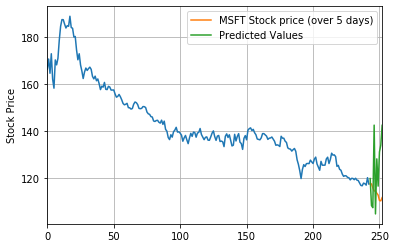

In [100]:
plt.show()
plt.ylabel('Stock Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(train_data)
plt.plot(x, test_data, label='MSFT Stock price (over 5 days)')
plt.plot(x,actual_predictions, label='Predicted Values')
ax = plt.subplot(111)
ax.legend()